In [1]:
from matplotlib import pyplot as plt
import numpy as np
import csv

In [2]:
# Function for producing a chart with some lines
def chart_lines (x_values, lines, xlabel, ylabel, name, vline=None):
    '''Print chart of x - y lines
    @param x_values: list of x_values
    @param lines:    list of lines, each being a dictionary with y_values and label
    @param xlabel:   label for the X axis
    @param ylabel:   label for the Y axis
    @param name:     name of the file to be produced with the chart
    @param vline:    vertical line in this value
    '''
    fig = plt.figure()
    fig = fig.add_axes([-1,-1,1,1])
    for line in lines:
        fig.plot(x_values, line['y_values'], label=line['label'])
    fig.axhline(y=0, color='black', linestyle='dashed', linewidth=0.5)
    if vline:
        fig.axvline(x=vline, color='black', linestyle='dashed', linewidth=0.5)
    fig.set_xlabel(xlabel)
    fig.set_ylabel(ylabel)
    fig.legend()
    plt.savefig(name+'.pdf', bbox_inches='tight', dpi=600)

In [3]:
# Coins minted per block
Mint = 6.25
# Kilo to Tera conversion
KiloTera = 1E9

# Blocks_T (T in days)
def Blocks_T(days):
    return 6 * 24 * days
# Mint_T (T in days)
def Mint_T(days):
    return Blocks_T(days) * Mint

# Scenarios:
#   - Fees collected, per day (BTC)
#   - Exchange rate of Bitcoin (EUR)
#   - Amortization costs of all miners (MEUR)
#   - Price of energy (EUR)
scenarios = []
with open('scenarios1.csv') as file:
    rows = csv.DictReader(file)
    for row in rows:
        scenario = {}
        # Name of scenario, for example, its date
        scenario['Name'] = row['Name']
        scenario['Fees_day'] = float(row['Fees_day'])
        scenario['EurBTC'] = float(row['EurBTC'])
        scenario['AmortEur_year'] = float(row['AmortEur_year'])
        scenario['EnergyPriceEur'] = float(row['EnergyPriceEur'])
        scenarios.append(scenario)
# Table with scenarios
with open("scenarios1_table.tex", "w") as f:
    for s in scenarios:
        row = f"{s['Name']} & {s['Fees_day']:.2f} & {s['EurBTC']:,.0f} & {s['AmortEur_year']:,.0f} & {s['EnergyPriceEur']:.2f}\\\\"
        print(row)
        print(row, file=f)

Low income/low cost & 30.00 & 10,000 & 0 & 0.01\\
Low income/high cost & 30.00 & 10,000 & 10,000 & 0.10\\
Medium income/medium cost & 100.00 & 30,000 & 5,000 & 0.03\\
High income/low cost & 300.00 & 100,000 & 0 & 0.01\\
High income/high cost & 300.00 & 100,000 & 10,000 & 0.10\\


In [15]:
# Compute max energy for period T (in days), in income/cost equilibrium (TWh)
def EnergyMax_T(days, Fees_day, EurBTC, AmortEur_year, EnergyPriceEur):
    energy = ((Mint_T(days) + Fees_day * days) * EurBTC - (AmortEur_year*1E6/365) * days) / EnergyPriceEur
    return energy / KiloTera

In [5]:
# Table with energy consumption per scenario
with open("scenarios1_energy_table.tex", "w") as f:
    for s in scenarios:
        EnergyMax_365 = EnergyMax_T(365, s['Fees_day'], s['EurBTC'], s['AmortEur_year'], s['EnergyPriceEur'])
        row = f"{s['Name']} & {s['Fees_day']:.2f} & {s['EurBTC']:,.0f} & {s['AmortEur_year']:,.0f} & {s['EnergyPriceEur']:.2f} & {EnergyMax_365:.2f}\\\\"
        print(row)
        print(row, file=f)

Low income/low cost & 30.00 & 10,000 & 0 & 0.01 & 339.45\\
Low income/high cost & 30.00 & 10,000 & 10,000 & 0.10 & -66.06\\
Medium income/medium cost & 100.00 & 30,000 & 5,000 & 0.03 & 198.33\\
High income/low cost & 300.00 & 100,000 & 0 & 0.01 & 4380.00\\
High income/high cost & 300.00 & 100,000 & 10,000 & 0.10 & 338.00\\


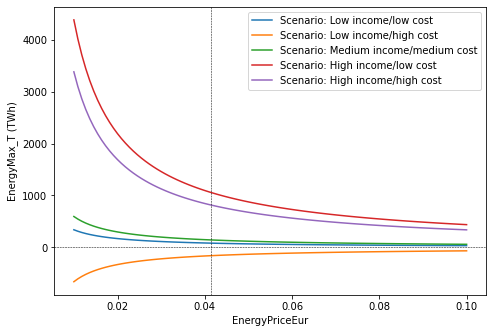

In [6]:
EnergyPriceEur_range = np.linspace(0.01, 0.1, 100)
lines = []
for s in scenarios:
    EnergyMax_365 = EnergyMax_T(365, s['Fees_day'], s['EurBTC'], s['AmortEur_year'], EnergyPriceEur_range)
    line = {'y_values': EnergyMax_365, 'label': "Scenario: " + s['Name']}
    lines.append(line)
chart_lines(EnergyPriceEur_range, lines, "EnergyPriceEur", "EnergyMax_T (TWh)", 'energy-energypriceeur', 0.05*0.83)

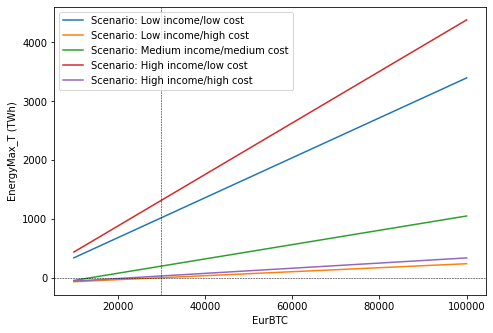

In [7]:
EurBTC_range = np.linspace(10000, 100000, 100)
lines = []
for s in scenarios:
    EnergyMax_365 = EnergyMax_T(365, s['Fees_day'], EurBTC_range, s['AmortEur_year'], s['EnergyPriceEur'])
    line = {'y_values': EnergyMax_365, 'label': "Scenario: " + s['Name']}
    lines.append(line)
chart_lines(EurBTC_range, lines, "EurBTC", "EnergyMax_T (TWh)", 'energy-eurbtc', 30000)

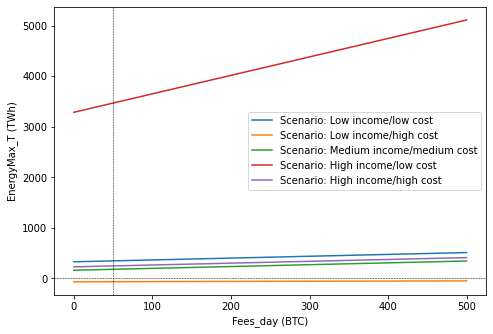

In [8]:
Fees_day_range = np.linspace(0, 500, 100)
lines = []
for s in scenarios:
    EnergyMax_365 = EnergyMax_T(365, Fees_day_range, s['EurBTC'], s['AmortEur_year'], s['EnergyPriceEur'])
    line = {'y_values': EnergyMax_365, 'label': "Scenario: " + s['Name']}
    lines.append(line)
chart_lines(Fees_day_range, lines, "Fees_day (BTC)", "EnergyMax_T (TWh)", 'energy-fees', 50)

In [9]:
# Computing amortization from hash
# Data about devices from https://www.asicminervalue.com/ (more effective, available on June 13th 2021)
# HashPower is 136.316 ExaHash/sec.(136.316*10^6 TeraHash/sec), estimated as of June 13th 2021
# in https://www.blockchain.com/charts/hash-rate
# We estimate an amortization period of 2 years
HashPower = 136.316 * 1E6
devices = []
with open("devices.csv", "r") as file:
    rows = csv.DictReader(file)
    for row in rows:
        device = {}
        device['Name'] = row['Name']
        device['DeviceHashPower'] = float(row['HashPower'])
        device['DevicePower'] = float(row['Power'])
        device['DeviceEur'] = float(row['PriceUSD']) * 0.83
        device['AmortEur_year'] = ((HashPower / device['DeviceHashPower']) * (device['DeviceEur']/2)) / 1E6
        devices.append(device)
        
with open("devices_table.tex", "w") as file:
    for d in devices:
        row = f"{d['Name']} & {d['DeviceHashPower']} & {d['DevicePower']} & {d['DeviceEur']:,.0f} & {d['AmortEur_year']:,.2f} \\\\"
        print(row)
        print(row, file=file)


Antminer S19j Pro (100 Th) & 100.0 & 3.05 & 7,080 & 4,825.52 \\
Antminer S19j Pro (110 Th) & 110.0 & 3.25 & 8,797 & 5,450.89 \\
Antminer S9 SE (16Th) & 16.0 & 1.28 & 829 & 3,532.16 \\


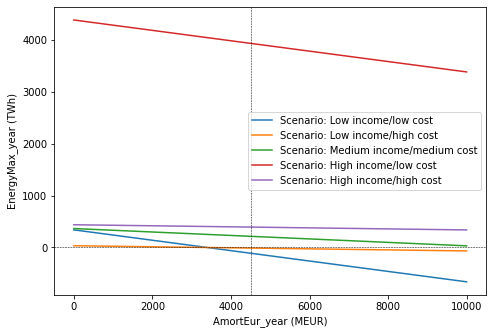

In [10]:
# Chart Energy_year vs Amort_year
# The 4,500 figure for the vertical line comes from a "regular" AmortEur_year in the previous table
AmortEur_year_range = np.linspace(0, 10000, 100)
lines = []
for s in scenarios:
    EnergyMax_365 = EnergyMax_T(365, s['Fees_day'], s['EurBTC'], AmortEur_year_range, s['EnergyPriceEur'])
    line = {'y_values': EnergyMax_365, 'label': "Scenario: " + s['Name']}
    lines.append(line)
chart_lines(AmortEur_year_range, lines, "AmortEur_year (MEUR)", "EnergyMax_year (TWh)", 'energy-amort', 4500)

In [11]:
# Let's compute AmF (Amoritization Factor, in Euro/KWh), based on
# AmortEurT (amortization for period T, in Euro) and
# EnergyT (energy consumed during period T, in KWh)
# Assuming amortization time of 2 years
# T is amortization time, in hours, to easy things
T = 2 * 365 * 24
with open("devices_amf_table.tex", "w") as file:
    for d in devices:
        d['AmortEurT'] = d['DeviceEur']
        d['EnergyT'] = d['DevicePower'] * T
        d['AmF'] = d['AmortEurT'] / d['EnergyT']
        row = f"{d['Name']} & {d['AmortEurT']:,.0f} & {d['EnergyT']:,.0f} & {d['AmF']:,.2f} \\\\"
        print(row)
        print(row, file=file)

Antminer S19j Pro (100 Th) & 7,080 & 53,436 & 0.13 \\
Antminer S19j Pro (110 Th) & 8,797 & 56,940 & 0.15 \\
Antminer S9 SE (16Th) & 829 & 22,426 & 0.04 \\


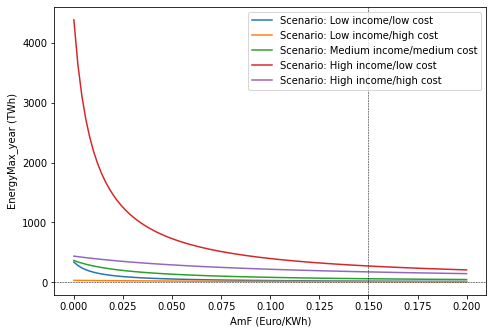

In [14]:
# Compute max energy for period T (in days), in income/cost equilibrium (TWh)
# based on AmF
def EnergyMax_T_AmF(days, Fees_day, EurBTC, AmF, EnergyPriceEur):
    energy = ((Mint_T(days) + Fees_day * days) * EurBTC) / (AmF + EnergyPriceEur)
    return energy / KiloTera

# Chart Energy vs AmF
AmF_range = np.linspace(0, 0.2, 100)
lines = []
for s in scenarios:
    EnergyMax_365 = EnergyMax_T_AmF(365, s['Fees_day'], s['EurBTC'], AmF_range, s['EnergyPriceEur'])
    line = {'y_values': EnergyMax_365, 'label': "Scenario: " + s['Name']}
    lines.append(line)
chart_lines(AmF_range, lines, "AmF (Euro/KWh)", "EnergyMax_year (TWh)", 'energy-amf', 0.15)

In [27]:
# Compute energy consumption for any day you may want (in TWh per year)
# Daily transaction fees (BTC)
Fees_day = 38.74
# Bitcoin to Euro exchange rate
BTCEur = 33100
# Aggregated amortization per year (Euro)
AmortEur_year = 5000
# Price of energy (Euro/KWh)
EnergyPriceEur = 0.03
Energy = EnergyMax_T(365, Fees_day, BTCEur, AmortEur_year, EnergyPriceEur)
print(Energy)

211.379577


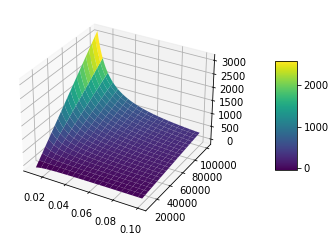

In [16]:
#EnergyPriceEur_range = np.linspace(0.01, 0.1, 60)
#EurBTC_lrange = np.linspace(10000, 100000, 60)
X, Y = np.meshgrid(EnergyPriceEur_range, EurBTC_range)
s = scenarios[2]
Z = EnergyMax_T(365, s['Fees_day'], Y, s['AmortEur_year'], X)

fig = plt.figure()
ax = plt.axes(projection='3d')
#chart = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
#                cmap='viridis', edgecolor='none')
chart = ax.plot_surface(X, Y, Z, rstride=5, cstride=5,
                cmap='viridis')
#chart = ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10,
#                cmap='viridis')
fig.colorbar(chart, shrink=0.5, aspect=5, pad=0.15, ax=ax)

plt.savefig("chart.png", bbox_inches='tight', dpi=600)

NameError: name 'Income_T' is not defined

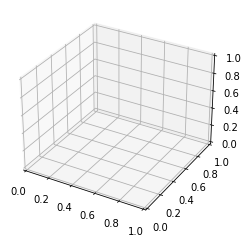

In [18]:
fig = plt.figure()
ax = plt.axes(projection='3d')
EurBTC = np.linspace(10000, 100000, 60)
EnergyPriceEur = np.linspace(0.01, 0.1, 60)
AmortEur_T = 0
X, Y = np.meshgrid(EnergyPriceEur, EurBTC)
Z = EnergyMax_T(Income_T, X, Y, AmortEur_T)


ax.contour3D(X, Y, Z, 50, cmap='binary')

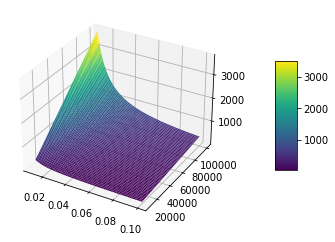

In [72]:
ax = plt.axes(projection='3d')
chart = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
fig.colorbar(chart, shrink=0.5, aspect=5, pad=0.15, ax=ax)

plt.savefig("chart.png", bbox_inches='tight', dpi=600)


In [18]:
import csv

# Scenarios
# Fees: https://www.blockchain.com/charts/transaction-fees (BTC, raw)
# EurBTC: https://trade.kraken.com/charts/KRAKEN:BTC-EUR?period=1d (max)
# https://www.blockchain.com/charts/hash-rate (million TH/s, or EH/s)
scenarios = []
with open('scenarios.csv') as file:
    rows = csv.DictReader(file)
    for row in rows:
        scenario = {}
        # Name of scenario, for example, its date
        scenario['Name'] = row['Name']
        # Fees obtained by all miners, per day (BTC)
        scenario['FeesDay'] = float(row['FeesDay'])
        # Exchange rate of BTC to EUR
        scenario['EurBTC'] = float(row['EurBTC'])
        # Total hash power of all miners (TH/s)
        scenario['HashPower'] = float(row['HashPower'])*1E6
        scenarios.append(scenario)
        
# Devices
# https://www.asicminervalue.com/ (more effective, available on June 13th 2021)
devices = []
with open('devices.csv') as file:
    rows = csv.DictReader(file)
    for row in rows:
        device = {}
        device['Name'] = row['Name']
        device['HashPower'] = float(row['HashPower'])
        device['DeviceEur'] = float(row['PriceUSD']) * 0.83
        devices.append(device)